<h1><center>Channel Flow</h1></center>

<h2><center>Solving the 2D Navier-Stokes</h2></center>

<h3><center>Bonus Notebook</h3></center>

For this bonus example, we will solve the incompressible Navier-Stokes equations. This problem builds-up on what we saw before, i.e. time-dependence, variational problem, but also adds some additional complexities, such as non-linearity, vector-valued variables, coupled equations.

In [2]:
import matplotlib.pyplot as plt
import numpy as np
from matplotlib import rcParams
rcParams['font.family'] = 'serif'
rcParams['font.size'] = 16
rcParams['figure.figsize'] = (12, 6)

In [3]:
from fenics import *
import dolfin
from mshr import *

### PDE Problem

The motion of the fluid is govenrned by the incompressible Navier-Stokes equations for the velocity $u$ and the pressure $p$

\begin{split}
\rho\left(\frac{\partial u}{\partial t} + u\nabla u\right) = & \nabla\cdot\sigma(u, p) + f, \\
\nabla\cdot u = & 0.
\end{split}

The second term on the right-hand side is a body force term and first term on the right-hand side is a short-hand notation of the stress tensor, which for a Newtonian fluid is given by

\begin{equation}
\sigma(u, p) = 2\mu S(u) - pI,
\end{equation}

where $I$ is the identity matrix and $S$ is the strain-rate tensor defined as

\begin{equation}
S(u) = \frac{1}{2}(\nabla u + (\nabla u)^{T})
\end{equation}

### Variational Formulation for the Channel Flow

Solving the Navier-Stokes is notoriously difficult, this is because we do not have an explicit equation for the pressure term that is present the momentum equation. One of the first method developed to solve it is based on a splitting strategy. We will use an improvement of this method, called the _incremental pressure correction scheme_ (IPCS). This scheme solve the N-S in three steps, first we compute a _tentative_ velocity $u^{\star}$ by advancing the N-S half a time-step, but using the pressure from the previous time-step $p^{n}$. We also linearize the nonlinear convective term by using the known velocity $u^n$ from the previous time step. This gives the following variational problem for the first step (we also use a more compact notation for the inner-product)

\begin{equation}
    \langle\rho\left(\frac{u^\star - u^n}{\Delta t}\right), v\rangle + \langle\rho u^n\cdot\nabla u^n, v\rangle + 
    \langle\sigma(u^{n+1/2}, p^{n}), S(v)\rangle + \langle p^n\cdot n, v\rangle_{\partial\Omega} + \langle \mu\nabla u^{n+1/2}\cdot n, v\rangle_{\partial\Omega} = \langle f^{n+1}, v\rangle.
\end{equation}

where $S(v)$ represent the symmetric part of $\nabla v$. The second step uses this tenative velocity $u^\star$ to compute the pressure $p^{n+1}$

\begin{equation}
\langle\nabla p^{n+1}, \nabla q\rangle = \langle\nabla p^{n}, \nabla q\rangle - \frac{1}{\Delta t}\langle\nabla\cdot u^\star, q\rangle
\end{equation}

where $q$ is a _scalar_-valued test function from the pressure space, whereas $v$ is a _vector_-valed test function form the velocity space. This expression is obtained by subtracting the momentum equation expressed at the tentative velocity $u^\star$ (with pressure $p^n$) from the momentum equation in terms of the velocity $u^{n+1}$, which results in

\begin{equation}
\frac{u^{n+1} - u^\star}{\Delta t} = -\nabla p^{n+1} + \nabla p^{n} 
\end{equation}

Re-arranging and taking the divergence, to impose continuity to the velocity field $u^{n+1}$, that is $\nabla\cdot u^{n+1} = 0$, results in

\begin{equation}
-\nabla\cdot\frac{u\star}{\Delta t} + \nabla^2 p^{n+1} - \nabla^2 p^n = 0, 
\end{equation}

which is most commonly know as the Poisson's equation (Again!) for the pressure. This results in the variational problem presented earlier.

The last step of the scheme is to compute the final velocity field $u^{n+1}$, from the equation obtained by the subtraction from the N-S at the final velocity from the N-S at the tentative velocity. Multiplying by $v$ we obtain the third variational problem

\begin{equation}
\langle u^{n+1}, v\rangle = \langle u^\star, v\rangle - \Delta t\langle\nabla(p^{n+1} - p^{n}), v\rangle
\end{equation}

This we will need to solve three variational problem at each time step to solve the incompressible Navier-Stokes.

### Pre-Processing

First we will need to define some global parameters, such as the simulation time, number of time-step and fluid properties.

In [4]:
T = 10.0
num_step = 500
dt = T / num_step
mu = 1
rho = 1

#### Mesh and Domain

We will solve the 2D Navier-Stokes in a square domain, with depth 1 unit and length 1 unit.

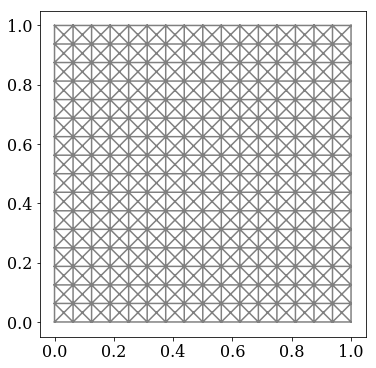

In [5]:
mesh = UnitSquareMesh(16, 16, 'crossed')
plot(mesh);

### Space Functions

Recall that $v$ is a vector-valued function from the velocity space, whereas $q$ is a scalar-valued function from the pressure space, these have to be specified differently

In [6]:
V = VectorFunctionSpace(mesh, 'P', 2)
Q = FunctionSpace(mesh, 'P', 1)

We also need to define the trial and test functions for the velocity and the pressure.

In [7]:
u = TrialFunction(V)
v = TestFunction(V)
p = TrialFunction(Q)
q = TestFunction(Q)

To store the various solutions, we will use the following variables, this time just setting them as functions of the different space.

In [8]:
u_n = Function(V)
u_ = Function(V)
p_n = Function(Q)
p_=  Function(Q)

### Boundary Conditions

We will need boundary conditions for the two walls of the channel and for the in- and out-flow surface. At the wall, the no-slip and no-flow conditions are imposed. This is equivalent in setting the two components of the velocity field to zero at the walls.

To force the flow, we will use a uniform pressure gradient in the channel, this is done by setting a pressure at the in-flow boundary and zero pressure at the out-flow.

Note that this time we need to use a neater notation for the boundary conditions, this improves computational time.

In [9]:
# define boundaries
inflow = 'near(x[0], 0)'
outflow = 'near(x[0], 1)'
walls = 'near(x[1], 0) || near(x[1], 1)'

We can no apply the corresponding boundary conditions to the appropriate function spaces

In [10]:
# define boundary conditions
bcu_noslip = DirichletBC(V, Constant((0, 0)), walls)
bcp_inflow = DirichletBC(Q, Constant(8), inflow)
bcp_outflow = DirichletBC(Q, Constant(0), outflow)
bcu = [bcu_noslip]
bcp = [bcp_inflow, bcp_outflow]

### Variational FEniCS formulation

We can now start the variational formulation, by setting some global variables

In [11]:
U = 0.5 * (u_n + u)
n = FacetNormal(mesh)
f = Constant((0, 0))
deltat = Constant(dt)
mu = Constant(mu)
rho = Constant(rho)

In [12]:
# strain-rate tensor
def S(u):
    return sym(nabla_grad(u))

In [13]:
# stress tensor
def sigma(u, p):
    return 2*mu*S(u) - p*Identity(len(u))

We can define the variational problem for step 1

In [14]:
# define variational problem for step 1
F1 = rho*dot((u - u_n) / deltat, v)*dx +\
     rho*dot(dot(u_n, nabla_grad(u_n)), v)*dx +\
     inner(sigma(U, p_n), S(v))*dx +\
     dot(p_n*n, v)*ds - dot(mu*nabla_grad(U)*n, v)*ds -\
     dot(f, v)*dx
a1 = lhs(F1)
L1 = rhs(F1)

Similarly for step 2

In [15]:
# define variational problem for step 2
a2 = dot(nabla_grad(p), nabla_grad(q))*dx
L2 = dot(nabla_grad(p_n), nabla_grad(q))*dx - (1/deltat)*div(u_)*q*dx

And finally for step 3

In [16]:
# define variational problem for step 3
a3 = dot(u, v)*dx
L3 = dot(u_, v)*dx - deltat*dot(nabla_grad(p_- p_n), v)*dx

When solving a variational problem in FEniCS, a lot of complex operations are hidden behind the `solve()` function, here we will do some of these operations explicitly to some computational time, as the assembly of the A matrix is only required once, as they do not vary, this prevents to computer from assemble them at each time-step!

In [17]:
A1 = assemble(a1)
A2 = assemble(a2)
A3 = assemble(a3)

We can now apply the boundary conditions to those matrices (also a step that FEniCS hiddes when using the `solve()` function.)

In [18]:
[bc.apply(A1) for bc in bcu]
[bc.apply(A2) for bc in bcp]

[None, None]

No we arrive to the main part of the program, the time-stepping algorithm

In [19]:
# time-stepping
t = 0
for n in range(num_step):
    
    # update time
    t += dt
    
    # Step 1: Tentative velocity step
    b1 = assemble(L1)
    [bc.apply(b1) for bc in bcu]
    solve(A1, u_.vector(), b1)
    
    # Step 2: Pressure correction step
    b2 = assemble(L2)
    [bc.apply(b2) for bc in bcp]
    solve(A2, p_.vector(), b2)
    
    # Step 2: Velocity correction step
    b3 = assemble(L3)
    solve(A3, u_.vector(), b3)
    
    # update solution
    u_n.assign(u_)
    p_n.assign(p_)

Now that we have a solution we can visualise the results.

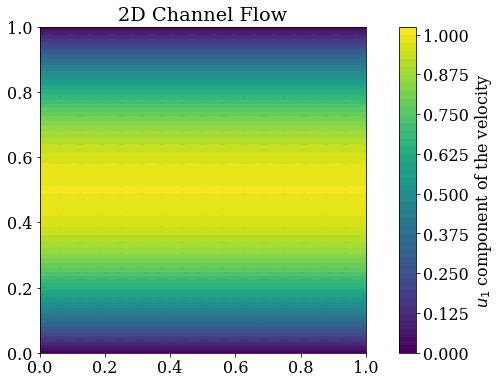

In [20]:
# Plot solution
p = plot(u_[0], title="2D Channel Flow", mode = "contourf")
plt.colorbar(p, label=r"$u_1$ component of the velocity");

Luckily (or not) we have an analytical solution to the channel/Poisseule flow! It can be found <a href="https://www.sciencedirect.com/science/article/pii/S0021999111002610">here</a>

\begin{equation}
u_e(y) = \frac{f_x}{2\nu}y(D - y),
\end{equation}

where $f_x$ is the applied horizontal pressure force, $\nu=1$ is the kinematic viscosity and $D$ is the depth of the channel.

We can thus extract the velocity profile from the FEniCS solution and compare it to this solution.

In [21]:
# extract profile, at middle of channel x=0.5
tol = 0.001
y = np.linspace(0 + tol, 1 - tol, 101)
points = [(0.5, y_) for y_ in y]
u_line = np.array([u_(point)[0] for point in points])

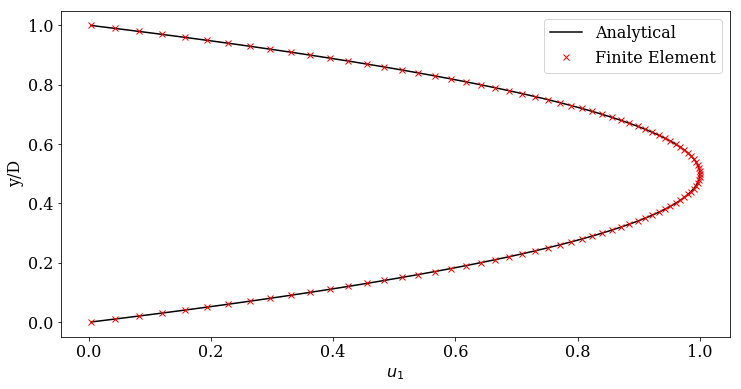

In [22]:
# compare to analytical solution
f_x = 8
nu = 1
u_e = f_x / (2 * nu) * y * (1- y)
plt.plot(u_e, y, '-k', label="Analytical")
plt.plot(u_line, y, 'xr', label="Finite Element")
plt.xlabel(r"$u_1$"), plt.ylabel("y/D")
plt.legend();